In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [3]:
dataset_path = Path('/home/deeplab/datasets/deepfashion/diordataset_custom')
data = pd.read_csv(dataset_path/'annotation_index.csv', sep=';')
data_pairs =pd.read_csv(dataset_path/'annotation_pairs.csv', sep=';')
print(data.shape, data_pairs.shape)
data.head(5)

(36836, 8) (65644, 3)


,image_file,image_group,keypoints_y,keypoints_x,img_height,img_width,gender,category
0,/home/deeplab/datasets/deepfashion/diordataset...,id_00003241_01,"[130, 246, 246, 390, 541, 246, 390, 534, 527, ...","[404, 407, 329, 308, 308, 486, 506, 527, 363, ...",1101,750,woman,Tees_Tanks
1,/home/deeplab/datasets/deepfashion/diordataset...,id_00003241_02,"[128, 240, 240, 387, 527, 240, 387, 527, 513, ...","[362, 362, 278, 264, 264, 446, 460, 474, 320, ...",1101,750,woman,Tees_Tanks
2,/home/deeplab/datasets/deepfashion/diordataset...,id_00003241_02,"[187, 350, 350, 609, 827, 350, 602, 834, 841, ...","[459, 364, 350, 398, 493, 378, 384, 487, 412, ...",1101,750,woman,Tees_Tanks
3,/home/deeplab/datasets/deepfashion/diordataset...,id_00003241_01,"[176, 330, 330, 622, 845, 330, -1, 845, 838, 1...","[433, 332, 363, 440, 523, 300, -1, 503, 412, 5...",1101,750,woman,Tees_Tanks
4,/home/deeplab/datasets/deepfashion/diordataset...,id_00003241_02,"[202, 389, 393, 647, 901, 386, 640, 901, 880, ...","[434, 427, 285, 250, 257, 568, 589, 617, 349, ...",1101,750,woman,Tees_Tanks


In [4]:
#catgories
seg_labels = {'background': 0, 'hat':1, 'hair': 2,  'face': 3, 'upper-clothes':4,
               'pants': 5, 'arm': 6, 'leg': 7, 'shoes':8,}
print(data[['category']].groupby(['category']).size().sort_values(ascending=False).reset_index())
data[['category']].groupby(['category']).size().sort_values(ascending=False).reset_index().category.to_list()
deepfashion_tops =set(['Tees_Tanks',
    'Blouses_Shirts',
    'Dresses',
    'Sweaters',
    'Jackets_Coats',
    'Sweatshirts_Hoodies',
    'Rompers_Jumpsuits',
    'Cardigans',
    'Graphic_Tees',
    'Shirts_Polos',
    'Jackets_Vests',
    'Suiting'])

deepfashion_bottoms = set([ 'Shorts',
    'Pants',
    'Skirts',
    'Denim',
    'Leggings',
    'Suiting'])
def label_from_category(category):
    if category in deepfashion_bottoms: return seg_labels['pants']
    if category in deepfashion_tops: return seg_labels['upper-clothes']
    return -1
    

               category     0
0            Tees_Tanks  9496
1               Dresses  6182
2        Blouses_Shirts  5334
3                Shorts  2885
4              Sweaters  2490
5                 Pants  1881
6         Jackets_Coats  1431
7     Rompers_Jumpsuits  1364
8                Skirts  1265
9             Cardigans  1131
10  Sweatshirts_Hoodies  1067
11         Graphic_Tees   817
12                Denim   539
13         Shirts_Polos   405
14        Jackets_Vests   281
15             Leggings   243
16              Suiting    25


In [5]:

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3')
list(reversed(list(model.modules())))[:10]

Loaded pretrained weights for efficientnet-b3


[MemoryEfficientSwish(),
 Linear(in_features=1536, out_features=1000, bias=True),
 Dropout(p=0.3, inplace=False),
 AdaptiveAvgPool2d(output_size=1),
 BatchNorm2d(1536, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Identity(),
 Conv2dStaticSamePadding(
   384, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False
   (static_padding): Identity()
 ),
 MemoryEfficientSwish(),
 BatchNorm2d(384, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Identity()]

/home/deeplab/datasets/deepfashion/diordataset_custom/img_highres/WOMEN/Tees_Tanks/id_00001923/02_1_front.jpg
(1101, 750) (array([0, 2, 3, 4, 5, 6, 7, 9], dtype=uint8), array([496028,  14511,  18717, 170318,   7280,  75360,  33382,  10154]))


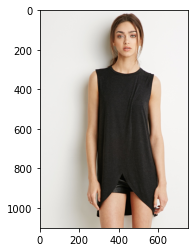

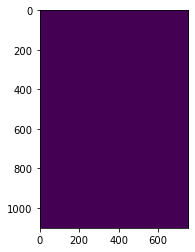

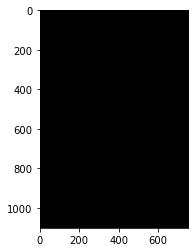

In [15]:
img_path = data.iloc[1100,0]
print(img_path)
img_rgb = cv2.imread(img_path)[:,:,[2,1,0]]
# img_rgb= Image.open(img_path)

seg_labels = {'background': 0, 'hat':1, 'hair': 2,  'face': 3, 'upper-clothes':4,
               'pants': 5, 'arm': 6, 'leg': 7, 'shoes':8}
# seg = np.load(img_path + '.seg.npz')['mask']
seg = np.array(Image.open(img_path + '.seg3.render.png'))

print(seg.shape, np.unique(seg, return_counts=True))
plt.imshow(img_rgb)
plt.show()
label = 4#seg_labels['pants']
plt.imshow(seg*(seg==label))
plt.show()
plt.imshow((seg==label)[...,np.newaxis] * img_rgb)
garment_img = (seg==label)[...,np.newaxis] * img_rgb

In [109]:
data[data.image_file.str.contains('_flat', regex=False)][:10]

,image_file,image_group,keypoints_y,keypoints_x,img_height,img_width,gender,category
1855,/home/deeplab/datasets/deepfashion/diordataset...,id_00003371_05,"[88, 199, 202, -1, -1, 195, -1, -1, 809, -1, -...","[383, 373, 163, -1, -1, 583, -1, -1, 236, -1, ...",1101,750,woman,Tees_Tanks
8773,/home/deeplab/datasets/deepfashion/diordataset...,id_00004611_02,"[107, 299, 296, 592, 875, 302, 586, 893, 781, ...","[356, 365, 196, 131, 90, 533, 592, 663, 267, -...",1101,750,woman,Sweatshirts_Hoodies
8931,/home/deeplab/datasets/deepfashion/diordataset...,id_00003798_02,"[328, 395, 395, 641, 851, 395, 635, 857, 821, ...","[379, 370, 223, 162, 114, 517, 571, 619, 277, ...",1101,750,woman,Sweatshirts_Hoodies
8985,/home/deeplab/datasets/deepfashion/diordataset...,id_00000139_02,"[82, 270, 273, 575, 852, 267, 587, 852, 747, -...","[400, 384, 215, 147, 116, 554, 615, 634, 276, ...",1101,750,woman,Sweatshirts_Hoodies
9076,/home/deeplab/datasets/deepfashion/diordataset...,id_00004007_01,"[110, 292, 298, 567, 798, 287, 545, 825, 803, ...","[377, 380, 216, 168, 141, 544, 614, 646, 291, ...",1101,750,woman,Sweatshirts_Hoodies
9131,/home/deeplab/datasets/deepfashion/diordataset...,id_00003708_01,"[245, 786, 811, 1683, 2459, 762, 1619, 2459, 2...","[1081, 1057, 580, 387, 306, 1534, 1776, 1841, ...",3205,2136,woman,Sweatshirts_Hoodies
11888,/home/deeplab/datasets/deepfashion/diordataset...,id_00001053_03,"[154, 408, 356, 600, 872, 461, 837, 928, 886, ...","[347, 382, 179, 19, 5, 584, 668, 619, 151, -1,...",1101,750,woman,Jackets_Coats
17388,/home/deeplab/datasets/deepfashion/diordataset...,id_00004777_02,"[83, 284, 290, 585, 840, 278, 562, 840, 798, -...","[359, 368, 193, 116, 98, 542, 637, 654, 264, -...",1101,750,woman,Cardigans
18136,/home/deeplab/datasets/deepfashion/diordataset...,id_00004535_01,"[152, 323, 331, 569, 777, 314, 534, 760, 765, ...","[338, 352, 204, 152, 106, 500, 581, 656, 268, ...",1101,750,woman,Graphic_Tees
18194,/home/deeplab/datasets/deepfashion/diordataset...,id_00002835_01,"[-1, 282, 285, -1, -1, 279, 464, -1, 874, -1, ...","[-1, 370, 171, -1, -1, 569, 712, -1, 266, -1, ...",1101,750,woman,Graphic_Tees


In [37]:
img_path=data.iloc[8931,0]
print(img_path)
def get_positive_pairs(image_file):
    category=data[data.image_file==image_file][:1].category.item()
    group_id = data[data.image_file==image_file][:1].image_group.item()
    grouped_ = data[data.image_group==group_id]
    files= grouped_[grouped_.image_file!=image_file].image_file.to_list()
    return category, files

category, img_files = get_positive_pairs(img_path)
print(category, img_files)
# data[data['image_group']==data[data['image_file']==img_path]['image_group']
# grouped_=pd.merge(data,data[data.image_file==img_path].image_group)


/home/deeplab/datasets/deepfashion/diordataset_custom/img_highres/WOMEN/Pants/id_00000878/01_1_front.jpg
Pants ['/home/deeplab/datasets/deepfashion/diordataset_custom/img_highres/WOMEN/Pants/id_00000878/01_7_additional.jpg']


In [41]:
def bbox(img):
    a = np.where(img != 0)
    if a[0].size==0 or a[1].size==0 :
        return None
    bbox = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1])
    return bbox

def garment_embedding(image_path, label):
    img_rgb = cv2.imread(image_path)[:,:,[2,1,0]]
    # seg = np.load(image_path + '.seg.npz')['mask']
    seg = np.array(Image.open(image_path + '.seg3.render.png'))
    bbox_img = bbox(seg*(seg==label))
    if bbox_img is None:
        return None
    print(bbox)
    garment_img= ((seg==label)[...,np.newaxis] * img_rgb)[bbox_img[0]:bbox_img[1],bbox_img[2]:bbox_img[3],:]
    # garment_img = (img_rgb)[bbox_img[0]:bbox_img[1],bbox_img[2]:bbox_img[3],:]
    print(cv2.resize(img_rgb,(garment_img.shape[1],garment_img.shape[0])).shape,garment_img.shape)
    plt.imshow(np.concatenate((cv2.resize(img_rgb,(garment_img.shape[1],garment_img.shape[0])),garment_img),1))
    plt.show()
    tfms = transforms.Compose([transforms.Resize(size=(224,224)), transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
    img = tfms(Image.fromarray(garment_img, mode ='RGB')).unsqueeze(0)
    print(img.shape)
    model.eval()
    with torch.no_grad():
        outputs = model.extract_features(img)
    n,c,h,w = outputs.shape
    return nn.AdaptiveAvgPool2d(output_size=1)(outputs).view(n,c)

emb1=garment_embedding(img_path,5)
emb2=garment_embedding(img_files[1],5)
emb3=garment_embedding(data.iloc[8937,0],5)
# bbox_img = bbox(seg*(seg==label))
# if bbox_img is not None:
#     garment_img= ((seg==label)[...,np.newaxis] * img_rgb)[bbox_img[0]:bbox_img[1],bbox_img[2]:bbox_img[3],:]
#     print(bbox_img)
#     print(garment_img.shape)
# garment_img[bbox_img[0]:bbox_img[0]
# np.sum(np.power(emb1-emb2,2),keepdims=False)
np.linalg.norm(emb1-emb2),np.linalg.norm(emb1-emb3),

IndexError: list index out of range

In [7]:
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(Image.fromarray(garment_img, mode ='RGB')).unsqueeze(0)
print(img.shape)
model.eval()
with torch.no_grad():
    outputs = model.extract_features(img)
n,c,h,w = outputs.shape
print(outputs.shape)
nn.AdaptiveAvgPool2d(output_size=1)(outputs).view(n,c)


torch.Size([1, 3, 298, 224])
torch.Size([1, 1536, 9, 7])


tensor([[ 0.3801, -0.1670, -0.2177,  ..., -0.2288, -0.1014,  0.4301]])

In [114]:
def 

AttributeError: 'numpy.ndarray' object has no attribute 'numel'

In [7]:
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(img_rgb).unsqueeze(0)
print(img.shape)
model.eval()
with torch.no_grad():
    outputs = model.extract_features(img)
n,c,h,w = outputs.shape
print(outputs.shape)
nn.AdaptiveAvgPool2d(output_size=1)(outputs).view(n,c)

NameError: name 'img_rgb' is not defined

In [49]:
list(reversed(list(model.modules())))[:10]

[MemoryEfficientSwish(),
 Linear(in_features=1536, out_features=1000, bias=True),
 Dropout(p=0.3, inplace=False),
 AdaptiveAvgPool2d(output_size=1),
 BatchNorm2d(1536, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Identity(),
 Conv2dStaticSamePadding(
   384, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False
   (static_padding): Identity()
 ),
 MemoryEfficientSwish(),
 BatchNorm2d(384, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Identity()]